# Reinforcement Learning Project : Crazy Taxi AI

Plan :

[1.Setting up the Environment and the agent](#1)  
[2.SARSA learning](#2)  
[3.Qlearning](#3)  
[4.Qlearning Back Propagation](#4)  

<a id="1"></a>
##  1.Setting up the Environment and the agent

In [10]:
import numpy as np
import random
from matplotlib import pyplot as plt

voies = 3
rows = 4

Our environnement consists in a road, represented by a grid. There are lanes (voies) and rows representing the vertical position of the objects.
On this road, there are cars - depicted by their lanes for each row. If there are no cars, their lane is equal to voies+1-, a taxi that is our agent - evolving on the last row, depicted the same way the cars are - and coins represented by their coordinates.

In [11]:
#Creates a list with the decomposition of i in base b : 
#i = a0 * b**k + a1 * b**(k-1)... --> [a0,a1...]
#We use this auxiliary function to explore all grids of cars
def base_convert(i, b):
    result = []
    while len(result)<b:
            t=(i % b)
            result=[t]+result
            i = i // b
    return result

print("Number 2 converted in base 4 :")
print(base_convert(2,4))
print()

#Init all the states
def init_states (voies,rows):
    grid_states=[]
    for i in range((voies+1)**(rows)):
        for j in range(voies):
            #We use the equivalence grids <->integer
            #Then we add the possible positions of the taxi -(j)
            grid_states+=[base_convert(i,voies+1) + [j]]
    real_states = []
    for state in grid_states :
        #Then we add the possible positions of the coin 
        #No coin scenario
        real_states.append(state+[rows,rows])
        for pos_vertical in range(rows):
            for pos_horizontal in range(voies):
                if state[pos_vertical]!=pos_horizontal :
                    #check if there is a car at this cell
                    real_states.append(state+[pos_vertical,pos_horizontal])
    return real_states

states = init_states(voies, rows)

print("exemple of a state :")
print(states[200])
print("There is a car in position (0,0)")
print("There is a car in position (1,0)")
print("There is a car in position (2,1)")
print("There is no car in the 4th row")
print("There is a coin in position (3,1)")
print()

#Hash function
def hash_s(s):
    name=""
    for j in s : 
        name=name+str(j)
    return name

print("State hashing function :")
print(hash_s(states[200]))
print()

#initialise actions value
def init_q(states) : 
    q={}
    for i in states :
        #the car can either drive straight, right or left, except if the taxi is at the border of the road
        name = hash_s(i)
        if i[rows]==0 :
            actions_l = {"1":0, "2":0}
            q[name]=actions_l
        elif i[rows]==voies-1 :
            actions_r = {"1":0, "0":0}
            q[name]=actions_r
        else: 
            actions_c= {"0":0, "1":0,"2":0}
            q[name]=actions_c
    return q
            
q=init_q(states)


Number 2 converted in base 4 :
[0, 0, 0, 2]

exemple of a state :
[0, 0, 1, 3, 0, 3, 1]
There is a car in position (0,0)
There is a car in position (1,0)
There is a car in position (2,1)
There is no car in the 4th row
There is a coin in position (3,1)

State hashing function :
0013031



In [12]:
def add_car(t) : 
    j = random.random()
    p=t*j
    pos = voies
    if (j)>0.5:
        pos = random.randint(0,voies-1)
    return pos

def add_heart(s):
    new_heart=[rows,rows]
    pos= random.random()
    apparition = False
    if pos>0.5 : 
        apparition = True
        test=False
        while test==False:
            horizontal_pos = random.randint(0,voies-1)
            if s[0] != horizontal_pos:
                test=True
                new_heart=[0,horizontal_pos]
    return new_heart, apparition
        

def next_state(s,a,t=2):
    impossible3 = [[0,1,2],[2,1,0],[0,1,1],[2,1,1]]
    impossible5 = [[0,1,3,1,0],[2,1,3,1,2]]
    #new_heart_position : 
    state = [add_car(t)]+s[0:(rows-1)]+[s[rows]+int(a)-1] + [s[rows+1]] + [s[rows+2]]  
    if state[rows+1]<rows : 
        state[rows+1]+=1
    if state[rows+1]==rows : 
        state[rows+2]=rows
    apparition = False
    while (state[0:3] in impossible3 or state[0:5] in impossible5):
        state[0] = add_car(t)
    if state[rows+1]== rows : 
        new_heart = add_heart(state)
        state[rows+1:rows+3] = new_heart[0]
        apparition =new_heart[1]
        
    return state, apparition

#Example
next_state([1,3,1,3,0,4,4],2)
    

([3, 1, 3, 1, 1, 4, 4], False)

In [13]:
#Defining the environment 
#Convention 
g=-1
Actions = ["l", "r", "k"]
s0 = {"grid" : np.zeros((3,4)) , "position" : 0}
#This won't be used finally 
def act_with_softmax(s, q):
    prob_a = softmax(q[s, :])
    cumsum_a = np.cumsum(prob_a)
    return np.where(np.random.rand() < cumsum_a)[0][0]

#Just a function to get the key with the maximal value in a dictionnary
def keywithmaxval(d):
    v = list(d.values())
    k = list(d.keys()) 
    return k[v.index(max(v))]
#The reward function 
#Gives -3 in case of a crash
#10 i case of coin catch
# 1 in case of survival
def reward(s,a):
    basic_reward=1
    pos_heart=s[rows+1]
    pos=s[rows]
    back= s[rows-1]
    front = s[rows-2]
    next_pos= pos+int(a)-1
    if (next_pos==front or next_pos==back):
        return -3
    if (pos_heart==rows-2 and next_pos == s[rows+2]) : 
        return 10
    return 1

#Epsilon greedy exploration policy
def act_with_epsilon_greedy(s, q,epsilon=0.5):
    local_q = q[hash_s(s)]
    local_list = list(local_q.keys())
    if np.random.rand() < epsilon:
        a = np.random.randint(0,len(local_list))
        return local_list[a]
    a = keywithmaxval(local_q)
    return a


#Find the action with the highest Q
def find_maxQ(s, q):
    local_q = q[hash_s(s)]
    local_list = list(local_q.values())
    return max(local_list)

#Example
act_with_epsilon_greedy([0,3,1,0,1,0,2],q) 

        

'0'

In [14]:
"""
Ce code faisait bouger des cercles

def taxi(x,y,height,width):
    draw_car(x,y,height,width,color='red')
    
def car(x,y,height,width):
    draw_car(x,y,height,width,color='blue')
    
def draw_car(x,y,height,width,color,voies=3,rows=4):
    #Dessine un cercle de centre (x,y) et de rayon r
    r = 20
    coef_x, coef_y = height/(rows-1) , width/(1+voies)
    x = x*coef_x+2*r
    y = y*coef_y+2*r
    Canevas.create_oval(x-r, y-r, x+r, y+r, outline=color, fill=color)
    
def print_state(s,i,t):
    global Hauteur, Largeur
    Canevas.delete("all")
    s = [-5 if x == 3 else x for x in s]
    for j in range(len(s[:-1])):
        car(s[j],j,Hauteur,Largeur)
    taxi(s[-1],len(s)-2,Hauteur,Largeur)
    Canevas.create_text(100, Largeur - 20, text = "Episode : "+str(i))
    Canevas.create_text(100, Largeur - 10, text = "Temps : "+str(t))
    Canevas.update_idletasks()
"""

#We define the graphical interface 

#Not really important to understand, it is mainly some code to show taxis, cars and coins.

import tkinter as tk
from PIL import Image, ImageTk  

image_car = Image.open("car.jpg")
image_car = image_car.resize((40,60))

image_taxi = Image.open("taxi.png") 
image_taxi = image_taxi.resize((40,60))

image_coin = Image.open("piece.jpeg")
image_coin = image_coin.resize((30,30))

Largeur = 450
Hauteur = 500

#bg = Image.open("road.jpeg") 
#bg = bg.resize((Hauteur,Largeur))

from time import sleep

class Model_interface:
    def __init__(self, Canevas):
        self.Canevas = Canevas
        #self.Canevas.title('Crazy Taxi')
    
    def draw_obj(self, x,y,height,width,photo,voies=3,rows=4):
        """ Dessine une photo de centre (x,y) """
        r = 20
        coef_x, coef_y = height/(rows-1) , width/(1+voies)
        x = x*coef_x+2*r
        y = y*coef_y+2*r
        self.Canevas.create_image(x-r, y-r, anchor = tk.NW, image=photo) 

    def taxi(self, x,y,height,width):
        self.draw_obj(x,y,height,width,photo = photo_taxi)

    def car(self, x,y,height,width):
        self.draw_obj(x,y,height,width,photo = photo_car)
    
    def coin(self, x,y,height,width):
        self.draw_obj(x,y,height,width,photo = photo_coin)
    

    def print_state(self, state,i,t):
        global Hauteur, Largeur
        self.Canevas.delete("all")
        s = state[:-2]
        s = [-5 if x == 3 else x for x in s]
        for j in range(len(s[:-1])):
            self.car(s[j],j,Hauteur,Largeur)
        self.taxi(s[-1],len(s)-2,Hauteur,Largeur)
        if (state[-2] != rows):
            self.coin(state[-1],state[-2],Hauteur,Largeur)
        sleep(0.1)
        self.Canevas.create_text(100, Largeur - 20, text = "Episode : "+str(i))
        self.Canevas.create_text(100, Largeur - 10, text = "Temps : "+str(t))
        self.Canevas.update_idletasks()
        self.Canevas.update() 

<a id="2"></a>
## 2.SARSA learning 

In [15]:
Mafenetre_sarsa = tk.Tk()
Mafenetre_sarsa.title('Crazy Taxi Sarsa')

photo_taxi = ImageTk.PhotoImage(image_taxi, master = Mafenetre_sarsa)
photo_car = ImageTk.PhotoImage(image_car, master = Mafenetre_sarsa)
photo_coin = ImageTk.PhotoImage(image_coin, master = Mafenetre_sarsa)
#background = ImageTk.PhotoImage(bg, master = Mafenetre)

Canevas = tk.Canvas(Mafenetre_sarsa, width = Largeur, height = Hauteur, bg = "white")
#Canevas.create_image(0,0, image = background, anchor = tk.NW)
Canevas.pack(padx =5, pady =5)
Interf = Model_interface(Canevas)

#Sarsa learning algorithm with 20000 episodes, epsilon=0.3, we take a normal situation with 3 lanes and 4 rows.
#voies =lanes
def sarsa_learning(num_episode = 20000, gamma=0.9, alpha=0.1,voies=3, rows=4, epsilon = 0.3):
    states= init_states(voies,rows)
    q = init_q(states) 
    # x stocks the ending times
    x=[]
    #This will be used to count the number of count caught
    bonuses = []
    cumul = 0
    #cumul is used to show some episodes "randomly"
    # proportions stocks the proportion of coins caught
    proportions = []
    for i in range(num_episode):
        #We begin with a random state, without coins, and without cars in the first rows.
        s = [random.randint(0,voies),random.randint(0,voies),3,3,random.randint(0,voies-1), rows, rows]
        r=0
        t=0
        apparitions = 0
        a = act_with_epsilon_greedy(s,q,epsilon*(10/(i+1)))
        bonus_score = 0
        #Display concerns the GUI
        Display = False
        cumul += 1/(i+1) 
        if(cumul>1):
            cumul=0
            Display = True
        
        while (r!=-3): #While no crash
            
            if(Display):
                Interf.print_state(s,i,t)
            
            t+=1
            r=reward(s,a)
            #Basic Sarsa Learning
            s_prime = next_state(s,a,t)
            apparition = s_prime[1]
            s_prime=s_prime[0]
            aprime = act_with_epsilon_greedy(s_prime, q, epsilon*np.exp(-i/100))
            delta = r + gamma* q[hash_s(s_prime)][aprime] - q[hash_s(s)][a]
            #Update of Q
            q[hash_s(s)][a] += alpha * delta
            s=s_prime
            a=aprime
            
            if r==10:
                #We got a coin !! 
                bonus_score+=1
            apparitions+=apparition
            if(t>1000): #We limit the iterations to 1000 
                break
        #We update the lists with the results of this episode
        x += [t]
        bonuses+=[bonus_score]
        if apparitions !=0 :
            proportions += [bonus_score/apparitions]
        else : 
            proportions +=[0]
            
            
    return x,bonuses, proportions

In [16]:
%%time
results = sarsa_learning()
#We stock the different results in order to plot them
Y=results[0]
bonuses = results[1]
proportions = results[2]

CPU times: user 23.4 s, sys: 483 ms, total: 23.9 s
Wall time: 1min 2s


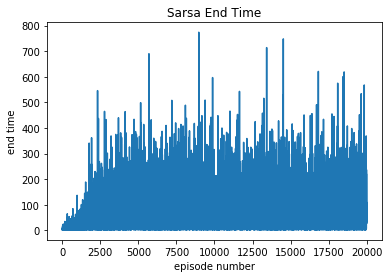

In [17]:
X = [i for i in range(len(Y))]
plt.plot(X,Y)
plt.xlabel("episode number")
plt.ylabel("end time")
plt.title("Sarsa End Time")
#plt.savefig("SARSA_endtime.png")
plt.show()  

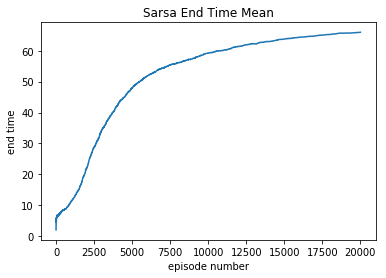

In [18]:
Y_prime = [np.mean(Y[0:i]) for i in range(1,len(Y))]
X = [i for i in range(len(Y_prime))]
plt.plot(X,Y_prime)
plt.xlabel("episode number")
plt.ylabel("end time")
plt.title("Sarsa End Time Mean")
#plt.savefig("SARSA_endtime_mean.png")
plt.show()  

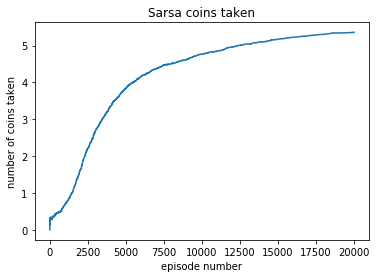

In [19]:
bonuses_means = [np.mean(bonuses[0:i]) for i in range(1,len(bonuses))]
X = [i for i in range(len(bonuses_means))]
plt.plot(X,bonuses_means)
plt.xlabel("episode number")
plt.title("Sarsa coins taken")
plt.ylabel("number of coins taken")
#plt.savefig("SarsaCoinstaken.png")
plt.show() 

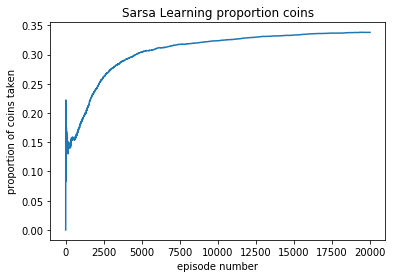

In [20]:
proportions_taken_means = [np.mean(proportions[0:i]) for i in range(1,len(proportions))]
X = [i for i in range(len(proportions_taken_means))]
plt.plot(X,proportions_taken_means)
plt.title("Sarsa Learning proportion coins")
plt.xlabel("episode number")
plt.ylabel("proportion of coins taken")
#plt.savefig("Sarsa_ProportionCoinsTaken.png")
plt.show()

<a id="3"></a>
## 3.Qlearning

In [21]:

Mafenetre_qlearning = tk.Tk()
Mafenetre_qlearning.title('Crazy Taxi Qlearning')

photo_taxi = ImageTk.PhotoImage(image_taxi, master = Mafenetre_qlearning)
photo_car = ImageTk.PhotoImage(image_car, master = Mafenetre_qlearning)
photo_coin = ImageTk.PhotoImage(image_coin, master = Mafenetre_qlearning)
#background = ImageTk.PhotoImage(bg, master = Mafenetre)

Canevas = tk.Canvas(Mafenetre_qlearning, width = Largeur, height = Hauteur, bg = "white")
#Canevas.create_image(0,0, image = background, anchor = tk.NW)
Canevas.pack(padx =5, pady =5)
Interf = Model_interface(Canevas)

# Q learning algorithm on 20000 episodes too
def q_learning(num_episode = 20000, gamma=0.9, alpha=0.1,voies=3, rows=4, epsilon = 0.3):
    states= init_states(voies,rows)
    #Same indexes and structures
    q = init_q(states) 
    x=[]
    bonuses = []
    proportions = []
    cumul = 0
    
    for i in range(num_episode):
        s = [random.randint(0,voies),random.randint(0,voies),3,3,random.randint(0,voies-1), rows, rows]
        r=0
        t=0
        apparitions = 0
        bonus_score=0
        Display = False
        
        cumul += 1/(i+1) 
        if(cumul>10):
            cumul=0
            Display = True
        
        while (r!=-3):
            if(Display):
                Interf.print_state(s,i,t)
            
            t+=1
            a = act_with_epsilon_greedy(s,q,epsilon*(10/(i+1)))
            r=reward(s,a)
            if (Display & r==-3):
                sleep(100)
            s_prime = next_state(s,a,t)
            apparition = s_prime[1]
            s_prime=s_prime[0]
            delta = r + gamma*find_maxQ(s_prime,q) - q[hash_s(s)][a]
            q[hash_s(s)][a] += alpha * delta
            s=s_prime
            if(t>1000):
                break
            if r==10 : 
                bonus_score +=1
            apparitions += apparition
        x += [t]
        bonuses +=[bonus_score]
        if apparitions!=0 : 
            proportions += [bonus_score/apparitions]
        else : 
            proportions += [0]
            
    return x, bonuses, proportions

In [22]:
%%time
results = q_learning()
Y=results[0]
bonuses = results[1]
proportions = results[2]    

CPU times: user 19.1 s, sys: 229 ms, total: 19.3 s
Wall time: 26.2 s


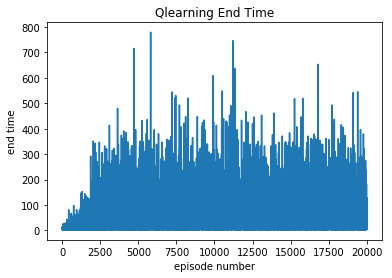

In [23]:
X = [i for i in range(len(Y))]
plt.plot(X,Y)
plt.xlabel("episode number")
plt.ylabel("end time")
plt.title("Qlearning End Time")
#plt.savefig("Qlearning_endtime.png")
plt.show()  

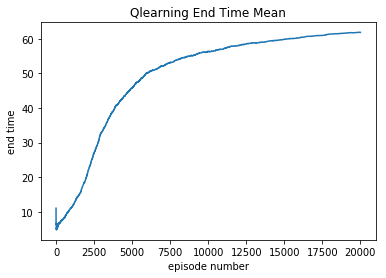

In [24]:
Y_prime = [np.mean(Y[0:i]) for i in range(1,len(Y))]
X = [i for i in range(len(Y_prime))]
plt.plot(X,Y_prime)
plt.xlabel("episode number")
plt.ylabel("end time")
plt.title("Qlearning End Time Mean")
#plt.savefig("Qlearning_endtime_mean.png")
plt.show()  

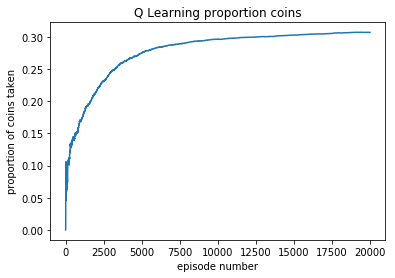

In [25]:
proportions_taken_means = [np.mean(proportions[0:i]) for i in range(1,len(proportions))]
X = [i for i in range(len(proportions_taken_means))]
plt.plot(X,proportions_taken_means)
plt.title("Q Learning proportion coins")
plt.xlabel("episode number")
plt.ylabel("proportion of coins taken")
#plt.savefig("Qlearning_ProportionCoinsTaken.png")
plt.show()

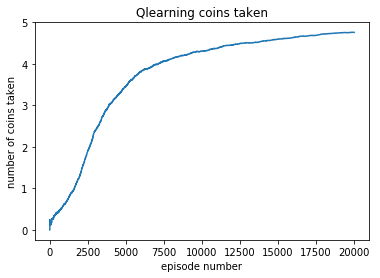

In [26]:
bonuses_means = [np.mean(bonuses[0:i]) for i in range(1,len(bonuses))]
X = [i for i in range(len(bonuses_means))]
plt.plot(X,bonuses_means)
plt.xlabel("episode number")
plt.title("Qlearning coins taken")
plt.ylabel("number of coins taken")
#plt.savefig("QlearningCoinstaken.png")
plt.show() 

<a id="4"></a>
## 4.Qlearning Back Propagation

In [41]:
Mafenetre_qlearningbp = tk.Tk()
Mafenetre_qlearningbp.title('Crazy Taxi Qlearning back prop')

photo_taxi = ImageTk.PhotoImage(image_taxi, master = Mafenetre_qlearningbp)
photo_car = ImageTk.PhotoImage(image_car, master = Mafenetre_qlearningbp)
photo_coin = ImageTk.PhotoImage(image_coin, master = Mafenetre_qlearningbp)
#background = ImageTk.PhotoImage(bg, master = Mafenetre)

Canevas = tk.Canvas(Mafenetre_qlearningbp, width = Largeur, height = Hauteur, bg = "white")
#Canevas.create_image(0,0, image = background, anchor = tk.NW)
Canevas.pack(padx =5, pady =5)
Interf = Model_interface(Canevas)
q = init_q(states)


#final algorithm and the most successful ones
#We will add a step in case of a crash that will negatively affect the previous actions
#This is meant to prevent inevitable crash cases by early preventive moves.
def q_learning_backprop(q, num_episode = 5000, gamma=0.9, alpha=0.1,voies=3, rows=4, epsilon = 0.3,register_size=3):
    states= init_states(voies,rows)
     
    x=[]
    #Begins like the others
    proportion_taken = []
    
    cumul = 0
    bonus_scores  = []
    for i in range(num_episode):
        s = [random.randint(0,voies),random.randint(0,voies),3,3,random.randint(0,voies-1), rows, rows]
        r=0
        t=0
        apparitions = 0
        bonus_score = 0 
        
        history = []
        
        Display = False
        cumul += 1/(i+1) 
        if(cumul>1):
            cumul=0
            Display = True
        
        while (r!=-3):
            # We just show one example for the 15000 episode
            if(Display):
                Interf.print_state(s,i,t)
                
            t+=1
            a = act_with_epsilon_greedy(s,q,epsilon*np.exp(-i/100))
            r=reward(s,a)
            # We stock in "history" the 5 last states, we will update their Q in case of a crash
            # We chose 5 because it is relevant in our case given the number of rows
            if len(history)<register_size :
                history.append((s,a))
            else :
                history=history[1:5]+[(s,a)]
                
            s_prime = next_state(s,a,t)
            apparition = s_prime[1]
            s_prime = s_prime[0]
            #Q learning update of the weigths
            delta = r + gamma*find_maxQ(s_prime,q) - q[hash_s(s)][a]
            q[hash_s(s)][a] += alpha * delta
            s=s_prime 
            apparitions += apparition
            #In case of a crash
            if r==-3 : 
                for j in range(len(history)) :
                    #Negative update for the states in the last history
                    #This is the backpropagation part
                    q[hash_s(history[j][0])][history[j][1]] += r * np.exp((j-register_size-1)/5)

                    if(Display):
                        print("Episode : " +  str(i))
                        print(history)
                        #Interf.print_state(history[j][0],"Mort : "+str(i),t+j)

            if r==10 : 
                bonus_score+=1
            if(t>1000):
                break
        x += [t]
        bonus_scores += [bonus_score]
        if apparitions != 0 :
            
            proportion_taken += [bonus_score/apparitions]
        else :
            proportion_taken += [0]
        #The rest is similar to the other algorithms
            
    return x, bonus_scores, proportion_taken

In [42]:
%%time
results_temp = q_learning_backprop(q)
results = q_learning_backprop(q)

Y=results[0]
bonuses = results[1]
proportions = results[2]

Episode : 1
[([2, 0, 3, 3, 0, 4, 4], '1'), ([3, 2, 0, 3, 0, 4, 4], '2'), ([3, 3, 2, 0, 1, 0, 2], '2')]
Episode : 1
[([2, 0, 3, 3, 0, 4, 4], '1'), ([3, 2, 0, 3, 0, 4, 4], '2'), ([3, 3, 2, 0, 1, 0, 2], '2')]
Episode : 1
[([2, 0, 3, 3, 0, 4, 4], '1'), ([3, 2, 0, 3, 0, 4, 4], '2'), ([3, 3, 2, 0, 1, 0, 2], '2')]
Episode : 6
[([3, 0, 3, 3, 2, 4, 4], '1'), ([3, 3, 0, 3, 2, 4, 4], '0'), ([0, 3, 3, 0, 1, 4, 4], '0')]
Episode : 6
[([3, 0, 3, 3, 2, 4, 4], '1'), ([3, 3, 0, 3, 2, 4, 4], '0'), ([0, 3, 3, 0, 1, 4, 4], '0')]
Episode : 6
[([3, 0, 3, 3, 2, 4, 4], '1'), ([3, 3, 0, 3, 2, 4, 4], '0'), ([0, 3, 3, 0, 1, 4, 4], '0')]
Episode : 19
[([3, 0, 3, 3, 0, 2, 2], '1'), ([3, 3, 0, 3, 0, 3, 2], '2'), ([3, 3, 3, 0, 1, 4, 4], '0')]
Episode : 19
[([3, 0, 3, 3, 0, 2, 2], '1'), ([3, 3, 0, 3, 0, 3, 2], '2'), ([3, 3, 3, 0, 1, 4, 4], '0')]
Episode : 19
[([3, 0, 3, 3, 0, 2, 2], '1'), ([3, 3, 0, 3, 0, 3, 2], '2'), ([3, 3, 3, 0, 1, 4, 4], '0')]
Episode : 55
[([0, 3, 2, 3, 0, 2, 0], '1'), ([2, 0, 3, 2, 0, 3, 0], '1

We can see with the amination for the 15000th episode that our agent already lasts until the maximum time and performs well.

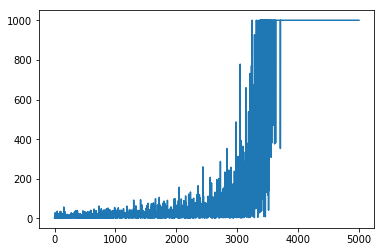

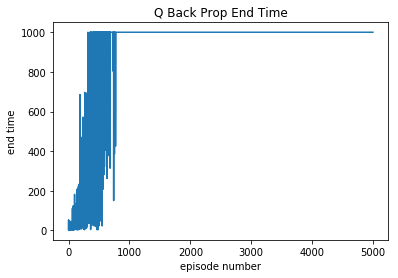

In [47]:
Y_temp = results_temp[0]
bonuses_temp = results_temp[1]
proportions_temp = results_temp[2]

X_temp = [i for i in range(len(Y_temp))]
plt.plot(X_temp,Y_temp)
plt.show()  

X = [i for i in range(len(Y))]
plt.plot(X,Y)
plt.xlabel("episode number")
plt.ylabel("end time")
plt.title("Q Back Prop End Time")
#plt.savefig("QBackProp_endtime.png")
plt.show()    

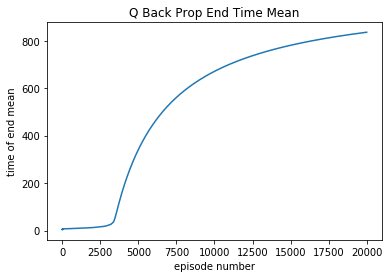

In [30]:
Y_prime = [np.mean(Y[0:i]) for i in range(1,len(Y))]
X = [i for i in range(len(Y_prime))]
plt.plot(X,Y_prime)
plt.xlabel("episode number")
plt.ylabel("time of end mean")
plt.title("Q Back Prop End Time Mean")
#plt.savefig("QbackPropETimemean.png")
plt.show()  

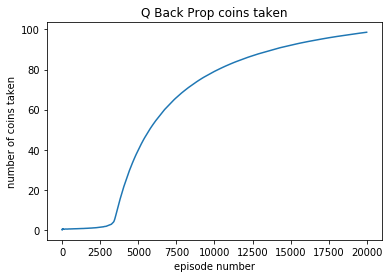

In [31]:
bonuses_means = [np.mean(bonuses[0:i]) for i in range(1,len(bonuses))]
X = [i for i in range(len(bonuses_means))]
plt.plot(X,bonuses_means)
plt.xlabel("episode number")
plt.title("Q Back Prop coins taken")
plt.ylabel("number of coins taken")
#plt.savefig("QbackpropCoinstaken.png")
plt.show()

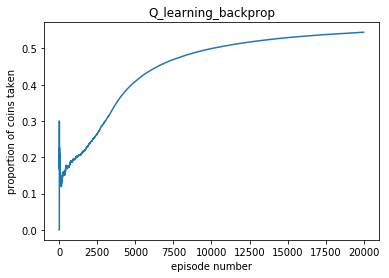

In [32]:
proportions_taken_means = [np.mean(proportions[0:i]) for i in range(1,len(proportions))]
X = [i for i in range(len(proportions_taken_means))]
plt.plot(X,proportions_taken_means)
plt.title("Q_learning_backprop")
plt.xlabel("episode number")
plt.ylabel("proportion of coins taken")
#plt.savefig("Qbackprop_ProportionCoinsTaken.png")
plt.show()

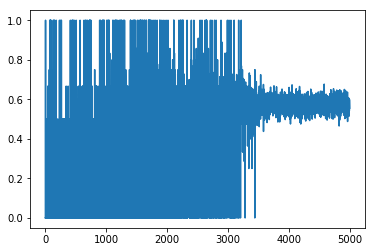

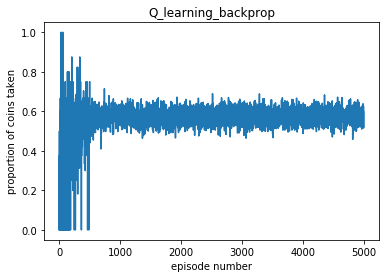

In [48]:
X = [i for i in range(len(proportions))]
plt.plot(X,proportions_temp)
plt.show()


plt.plot(X,proportions)
plt.title("Q_learning_backprop")
plt.xlabel("episode number")
plt.ylabel("proportion of coins taken")
#plt.savefig("Qbackprop_ProportionCoinsTaken.png")
plt.show()

In [49]:
Mafenetre_qlearningbp.destroy()